In [2]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
from scipy import stats
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, PowerTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest, mutual_info_classif, RFE
from sklearn.utils.validation import check_is_fitted
from sklearn import set_config
set_config(transform_output="pandas")

pd.set_option("display.max_columns", 250)
pd.set_option("display.width", 150)


## 1) Carga y preparación inicial  
- El archivo viene separado por espacios (whitespace).  
- Los faltantes están codificados como `'?'` en el dataset original; aquí los parseamos como `NaN`.  


In [3]:
# Paths candidatos (ajusta si tu carpeta cambia)
CANDIDATES = [
    Path("german_credit_data.txt"),
    Path("../data/german_credit_data.txt"),
]
DATA_PATH = next((p for p in CANDIDATES if p.exists()), None)
DATA_PATH


WindowsPath('german_credit_data.txt')

In [4]:
cols = [
    "status_account","duration","credit_history","purpose","credit_amount","savings","employment_since","installment_rate",
    "personal_status","other_debtors","residence_since","property","age","other_installments","housing","num_credits","job",
    "num_liable","telephone","foreign_worker","target","payment_behavior","debt_to_income_ratio","num_previous_loans",
    "monthly_income","credit_duration_ratio","age_employment_interaction","bmi","gender"
]

df = pd.read_csv(DATA_PATH, sep=r"\s+", header=None, na_values=["?"], engine="python")
df.columns = cols

print("Shape:", df.shape)
display(df.head())


Shape: (1250, 29)


,status_account,duration,credit_history,purpose,credit_amount,savings,employment_since,installment_rate,personal_status,other_debtors,residence_since,property,age,other_installments,housing,num_credits,job,num_liable,telephone,foreign_worker,target,payment_behavior,debt_to_income_ratio,num_previous_loans,monthly_income,credit_duration_ratio,age_employment_interaction,bmi,gender
0,checking_below_0,6.0,critical_account,radio_television,1169.0,no_savings_account,employed_above_7yr,4.0,male_single,none,4,real_estate,67.0,no_installment,own,2,skilled_employee,1,has_telephone,foreign_worker_yes,good_client,payment_excellent,0.084,3.0,500.0,194.83,469.0,27.0,Female
1,checking_0_to_200,48.0,existing_paid_duly,radio_television,5951.0,savings_below_100,employed_1_to_4yr,2.0,female_divorced_married,none,2,real_estate,22.0,no_installment,own,1,skilled_employee,1,no_telephone,foreign_worker_yes,bad_client,payment_fair,0.600,0.0,500.0,123.98,55.0,24.4,Male
2,no_checking_account,12.0,critical_account,education,2096.0,savings_below_100,employed_4_to_7yr,2.0,male_single,none,3,real_estate,49.0,no_installment,own,1,unskilled_resident,2,no_telephone,foreign_worker_yes,good_client,payment_excellent,0.099,3.0,500.0,174.67,269.5,27.6,Male
3,checking_below_0,42.0,existing_paid_duly,furniture_equipment,7882.0,savings_below_100,employed_4_to_7yr,2.0,male_single,guarantor,4,building_society_savings,45.0,no_installment,for_free,1,skilled_employee,2,no_telephone,foreign_worker_yes,good_client,payment_fair,0.165,5.0,1050.0,187.67,247.5,NaN,Female
4,checking_below_0,24.0,delay_in_past,car_new,4870.0,savings_below_100,employed_1_to_4yr,3.0,male_single,none,4,no_property,53.0,no_installment,for_free,2,skilled_employee,2,no_telephone,foreign_worker_yes,bad_client,payment_excellent,0.463,1.0,500.0,202.92,132.5,24.1,Female


### Limpieza previa: valores fuera de rangos plausibles
En lugar de eliminar filas, convertimos valores *imposibles* a `NaN` para que el pipeline los trate como faltantes.
Esto evita “ensuciar” escalado/transformaciones y reduce el impacto de errores de carga.


In [5]:
# Bounds plausibles (ajusta si tu conocimiento de dominio cambia)
RANGOS_PLAUSIBLES = {
    "duration": (4, 72),
    "credit_amount": (250, 20000),
    "installment_rate": (1, 4),
    "residence_since": (1, 4),
    "age": (18, 100),
    "num_credits": (1, 10),
    "num_liable": (1, 10),
    "debt_to_income_ratio": (0, 1),
    "num_previous_loans": (0, 50),
    "monthly_income": (0, 1_000_000),
    "credit_duration_ratio": (0, 1_000_000),
    "age_employment_interaction": (0, 1_000_000),
    "bmi": (10, 80),
}

def aplicar_rangos_plausibles(df, rangos_plausible):
    df_limpio = df.copy()

    for col, (min_val, max_val) in rangos_plausible.items():
        if col not in df_limpio.columns:
            continue  # seguridad
### Generamos columnas booleanas para luego identificar por fila & columna don imputar NAN
        mask_fuera = (
            df_limpio[col].notna() &
            ~df_limpio[col].between(min_val, max_val)
        )
##Imputamos Nan en valores fuera de rango con .loc especificando columna y fila
        df_limpio.loc[mask_fuera, col] = np.nan

    return df_limpio


In [6]:
### Imputamos nan en valores fuera de rango para posteriormente tratarlos con imputación y no eliminarlos
print(f"Antes de este tratamiento existian {df.isna().sum().sum()} valores faltantes")

Antes de este tratamiento existian 348 valores faltantes


In [7]:
df=aplicar_rangos_plausibles(df, RANGOS_PLAUSIBLES).copy()
print(f"Despúes del tratamiento hay {df.isna().sum().sum()} valores")

Despúes del tratamiento hay 381 valores


In [8]:
# Target a binario (1 = bad_client, 0 = good_client) para facilitar métricas/selección de variables
y = (df["target"] == "bad_client").astype(int)
X = df.drop(columns=["target"])

y.value_counts(normalize=True).rename({0:"good_client", 1:"bad_client"})

target
good_client    0.6984
bad_client     0.3016
Name: proportion, dtype: float64

## 2) Split Train/Test (para evitar leakage)  
Todo lo que “aprenda” parámetros del dataset se debe ajustar **solo en train**.  


In [9]:
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Shape de los datos de entrenamiento {X_train.shape}")
print(f"Shape de los datos de evaluacion {X_test.shape}")
print(f"Shape de y en entrenamiento {y_train.shape}")
print(f"Shape de y en evaluacion {y_test.shape}")

Shape de los datos de entrenamiento (1000, 28)
Shape de los datos de evaluacion (250, 28)
Shape de y en entrenamiento (1000,)
Shape de y en evaluacion (250,)


In [10]:
## A) Tratamiento de valores faltantes  
### A.1 Cuantificación  
missing_counts=X_train.isna().sum()
missing_pct=round((X_train.isna().sum()/X_train.shape[0])*100,2)

df_valores_faltantes= pd.DataFrame()
df_valores_faltantes["cantidad"] = missing_counts
df_valores_faltantes["porcentaje"] = missing_pct

df_valores_faltantes.sort_values(by="cantidad", ascending=False)


,cantidad,porcentaje
installment_rate,38,3.8
savings,37,3.7
credit_amount,30,3.0
credit_duration_ratio,30,3.0
monthly_income,29,2.9
age,29,2.9
duration,28,2.8
debt_to_income_ratio,26,2.6
property,26,2.6
num_previous_loans,25,2.5


### A.2 Eliminación de filas (si procede)  
Como regla práctica, si una fila tiene **muchos** faltantes (p.ej., ≥ 6 columnas), la imputación puede volverse poco confiable.  
Aquí evaluamos cuántas filas cumplen eso y, si son pocas, las eliminamos **solo en train y test** (misma regla).  


In [11]:
df.isna().sum(axis=1)

0       0
1       0
2       0
3       1
4       0
       ..
1245    0
1246    3
1247    0
1248    6
1249    0
Length: 1250, dtype: int64

In [12]:
nan_threshold=6

train_drop_mask = (X_train.isna().sum(axis=1) >= nan_threshold)
test_drop_mask  = (X_test.isna().sum(axis=1) >= nan_threshold)

print(f"Numero de filas con mayor igual a 6 columnas con NAN en train {train_drop_mask.sum()}" )
print(f"Numero de filas con mayor igual a 6 columnas con NAN en test {test_drop_mask.sum()}" )

Numero de filas con mayor igual a 6 columnas con NAN en train 23
Numero de filas con mayor igual a 6 columnas con NAN en test 2


In [13]:
X_train=X_train.loc[~train_drop_mask].copy()
y_train=y_train.loc[~train_drop_mask].copy()

X_test=X_test.loc[~test_drop_mask].copy()
y_test=y_test.loc[~test_drop_mask].copy()

print(f"shape de X_train= {X_train.shape}")
print(f"shape de X_test= {X_test.shape}")

shape de X_train= (977, 28)
shape de X_test= (248, 28)


## B) Detección y tratamiento de outliers  
En scoring, normalmente **no se eliminan** outliers a menos que haya evidencia clara de error.

Se pide: identificar outliers con **≥ 2 métodos**. Aquí usamos:  
1) Método IQR (Tukey)  
2) Z-score (|z| > 3)  


In [14]:
numeric_cols=X_train.select_dtypes(include=['number']).columns.to_list()

In [15]:
print(numeric_cols)
print(f"Cantidad de columnas numericas {len(numeric_cols)}")

['duration', 'credit_amount', 'installment_rate', 'residence_since', 'age', 'num_credits', 'num_liable', 'debt_to_income_ratio', 'num_previous_loans', 'monthly_income', 'credit_duration_ratio', 'age_employment_interaction', 'bmi']
Cantidad de columnas numericas 13


In [16]:
## Z-Score

def detect_outliers_z_score(s, threshold):
    s = pd.to_numeric(s, errors="coerce")     # asegura numérico, convierte basura a N
    Z_score=np.abs(stats.zscore(s,  nan_policy="omit")) #importante mencionar que pueden haber nan y omitirlos
    return Z_score > threshold

outliers_zscore={}

for col in (X_train[numeric_cols]):
    outliers_zscore[col]=detect_outliers_z_score(X_train[col], threshold=3)
    # n_outliers=(outliers_zscore[col]==True).sum()
    # l=len(df)
    #print(f"Atributo:{col}, presenta {n_outliers}, que corresponde a un porcentaje de {round((n_outliers/l)*10,2)}")
zscore_results=[]
l=X_train.shape[0]

for col in numeric_cols:
    num_outliers=outliers_zscore[col].sum()
    zscore_results.append({"Atributo":col,
                           "Num_Outliers":num_outliers, 
                           "Porcentaje":round((num_outliers/l)*100,2)  })

df_outliers_zscore=pd.DataFrame(zscore_results).sort_values(by="Num_Outliers", ascending=False)
df_outliers_zscore.head(13)

,Atributo,Num_Outliers,Porcentaje
9,monthly_income,28,2.87
1,credit_amount,23,2.35
0,duration,14,1.43
4,age,11,1.13
10,credit_duration_ratio,10,1.02
8,num_previous_loans,6,0.61
5,num_credits,5,0.51
12,bmi,2,0.20
7,debt_to_income_ratio,1,0.10
11,age_employment_interaction,1,0.10


In [17]:
## Iqr 

def detect_outliers_iqr(data, multiplier):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - (multiplier * IQR)
    upper_bound = Q3 + (multiplier * IQR)
    return (data < lower_bound) | (data > upper_bound)

outliers_iqr={}

for col in numeric_cols:
    outliers_iqr[col]=detect_outliers_iqr(df[col], 1.5)

results_outliers_iqr=[]
l=X_train.shape[0]
for col in numeric_cols:
    n_outliers=outliers_iqr[col].sum()
    porcentaje=round((n_outliers/l)*100,2)
    results_outliers_iqr.append({"Atributo":col,"Num_Outliers":n_outliers, "Porcentaje":porcentaje})

df_outliers_iqr=pd.DataFrame(results_outliers_iqr).sort_values(by="Num_Outliers", ascending=False)
df_outliers_iqr

,Atributo,Num_Outliers,Porcentaje
9,monthly_income,304,31.12
6,num_liable,190,19.45
1,credit_amount,98,10.03
0,duration,89,9.11
10,credit_duration_ratio,48,4.91
4,age,35,3.58
11,age_employment_interaction,10,1.02
5,num_credits,6,0.61
12,bmi,4,0.41
8,num_previous_loans,3,0.31


### B.1 Tratamiento elegido: *IQR capping* dentro del pipeline  
- Es robusto y fácil de justificar.  
- Evita eliminar datos (importante en scoring).  
- Los límites se calculan **solo en train** al hacer `.fit()`.  


In [18]:
class IQRClipper(BaseEstimator, TransformerMixin):
    """Winsorizing/clipping usando límites IQR por columna."""

    def __init__(self, multiplier):
        self.multiplier=multiplier
        self.bounds=None
        self.numeric_cols=None

    ### FUNCION DE APRENDIZAJE 
    def fit(self, X, y=None):
        X_df=X.copy()

        self.bounds={}
        self.numeric_cols=X_df.select_dtypes(include=['number']).columns.to_list()
        for col in self.numeric_cols:
                Q1 = X_df[col].quantile(0.25)
                Q3 = X_df[col].quantile(0.75)
                IQR = Q3 - Q1
                lower_bound = Q1 - (self.multiplier * IQR)
                upper_bound = Q3 + (self.multiplier * IQR)
                self.bounds[col]=(lower_bound, upper_bound)
        return self
    ### FUNCION DE TRANSFORMACION
    def transform(self, X):
        check_is_fitted(self, ["bounds", "numeric_cols"]) #Validar que fit se haya llamado

        X_df=X.copy()
        for col in self.numeric_cols:
             lower, upper = self.bounds[col]
             X_df[col] = X_df[col].clip(lower=lower, upper=upper)
        return X_df

    def get_feature_names_out(self, input_features=None):
        return input_features

## C) Encoding de variables categóricas  
Separamos categóricas en:  
- **Ordinales** (tienen orden natural): `employment_since`, `savings`, `status_account`, `payment_behavior`  
- **Nominales** (sin orden): el resto  

Además, para nominales usamos `OneHotEncoder` con manejo de **categorías raras** (agrupadas como “infrecuentes”).  


In [19]:
# Columnas ordinales según dataset
ordinal_cols = ["status_account", "savings", "employment_since", "payment_behavior"]

# Ordenes (incluimos 'missing' al inicio por si hay imputación constante)
status_order = ["missing", "checking_below_0", "checking_0_to_200", "checking_above_200", "no_checking_account"]
savings_order = ["missing", "no_savings_account", "savings_below_100", "savings_100_to_500", "savings_500_to_1000", "savings_above_1000"]
employment_order = ["missing", "unemployed", "employed_below_1yr", "employed_1_to_4yr", "employed_4_to_7yr", "employed_above_7yr"]
payment_order = ["missing", "payment_excellent", "payment_good", "payment_fair", "payment_poor"]

ordinal_categories = [status_order, savings_order, employment_order, payment_order]

# Categóricas nominales = todas las categóricas excepto ordinales
# (asumimos que lo que no es numérico base es categórico)
categorical_all = [c for c in X_train.columns if c not in numeric_cols]
nominal_cols=[c for c in categorical_all if c not in ordinal_cols]

print("Numéricas:", len(numeric_cols))
print("Ordinales:", ordinal_cols)
print("Nominales:", len(nominal_cols), nominal_cols[:8], "...")

Numéricas: 13
Ordinales: ['status_account', 'savings', 'employment_since', 'payment_behavior']
Nominales: 11 ['credit_history', 'purpose', 'personal_status', 'other_debtors', 'property', 'other_installments', 'housing', 'job'] ...


In [20]:
ordinal_cols

['status_account', 'savings', 'employment_since', 'payment_behavior']

## D) Transformación de variables (escalado / normalidad)  
- Para modelos lineales (LogReg), SVM, KNN, redes, etc., conviene escalar.  
- Para acercar distribuciones a “más normales” (sobre todo si hay asimetría), usamos **PowerTransformer (Yeo-Johnson)** en numéricas.  
  - Ventaja: funciona incluso si hubiera ceros o valores cercanos a cero.  


## E) Feature Engineering (≥ 3 features nuevas)  
Creamos 4 features nuevas basadas en razonamiento de negocio:  

overall_stability = residence_since + employment_since

proxy de estabilidad general (mayor permanencia residencial y laboral, menor riesgo esperado).

financial_pressure = installment_rate × debt_to_income_ratio

proxy de presión financiera combinada (cuotas altas junto con alto nivel de endeudamiento).

high_risk_profile = 1 si (payment_behavior bajo ∧ installment_rate alto), 0 en caso contrario

bandera binaria de “perfil de alto riesgo” basada en una regla experta.

credit_experience = 1 si num_previous_loans ≥ 1, 0 en caso contrario


In [21]:
## installment_rate, residence_since -->numerico
##employment_since, payment_behavior  --> ordinal

class FeatureEngineer(BaseEstimator, TransformerMixin):
    def __init__(self, employment_order=employment_order, payment_order=payment_order):
        self.employment_order=employment_order  
        self.payment_order=payment_order 

    def fit(self, X, y=None):
        self.dict_employment_order_={}
        self.dict_payment_order_={}
        i=0
        j=0

        for c in self.employment_order:
            self.dict_employment_order_[c]=i
            i+=1
        
        for c in self.payment_order:
            self.dict_payment_order_[c]=j
            j+=1
        return self

    def transform(self, X):
        check_is_fitted(self, ["dict_employment_order_", "dict_payment_order_"])  # aqui atributos aprendidos
        
        ##Generamos la transformación de columnas categoricas ordinales a ordinales numericas
        X_df = X.copy()

        
        # Si vienen NaN, primero llévalos a "missing" para que mapeen
        X_df["employment_since"]  = X_df["employment_since"].fillna("missing")
        X_df["payment_behavior"]  = X_df["payment_behavior"].fillna("missing")


        # Temporales numéricas (solo para features nuevas)
        X_df["employment_since_order"]=X_df["employment_since"].map(self.dict_employment_order_)
        X_df["payment_behavior_order"]=X_df["payment_behavior"].map(self.dict_payment_order_)
    
        # Solo numéricas reales (NO employment_since)
        for col in ["residence_since", "installment_rate", "debt_to_income_ratio", "num_previous_loans"]:
            if col in X_df.columns:
                X_df[col] = pd.to_numeric(X_df[col], errors="coerce")

        # Nuevas features
        X_df["overall_stability"] = X_df["residence_since"] + X_df["employment_since_order"]

        # financial_pressure
        X_df["financial_pressure"] =  X_df["installment_rate"] *  X_df["debt_to_income_ratio"]

        # high_risk_profile
        X_df["high_risk_profile"] = ((X_df["payment_behavior_order"] <= 1) & (X_df["installment_rate"] >= 3)).astype(int)

        # credit_experience
        X_df["credit_experience"] = (X_df["num_previous_loans"] >= 1).astype(int)
        # Aplicar transformación usando lo aprendido en fit
        # X_df["col"] = X_df["col"].clip(...)
        
        # Drop temporales
        X_df=X_df.drop(columns=["employment_since_order","payment_behavior_order"]).copy()
        return X_df
    
    def get_feature_names_out(self, input_features=None):
        if input_features is None:
            # fallback: si no te pasan nombres, devuelve los nombres aprendidos en fit si existieran
            return getattr(self, "feature_names_in_", None)

        # Asegura lista
        input_features = list(input_features)

        new_features = [
            "overall_stability",
            "financial_pressure",
            "high_risk_profile",
            "credit_experience",
        ]

        # Si por alguna razón ya existieran (para evitar duplicados)
        out = input_features.copy()
        for nf in new_features:
            if nf not in out:
                out.append(nf)

        return out



In [22]:
### Probando el transfomer de FeatureEngineer

# Instanciar el transformer
fe=FeatureEngineer(employment_order=employment_order, payment_order=payment_order)

# ENTRENAMIENTO (fit)
fe.fit(X_train)

X_fe_prueba=fe.transform(X_train.head(5))
X_fe_prueba.head()


,status_account,duration,credit_history,purpose,credit_amount,savings,employment_since,installment_rate,personal_status,other_debtors,residence_since,property,age,other_installments,housing,num_credits,job,num_liable,telephone,foreign_worker,payment_behavior,debt_to_income_ratio,num_previous_loans,monthly_income,credit_duration_ratio,age_employment_interaction,bmi,gender,overall_stability,financial_pressure,high_risk_profile,credit_experience
767,no_checking_account,10.0,existing_paid_duly,car_used,2901.0,no_savings_account,employed_below_1yr,1.0,female_divorced_married,none,4.0,real_estate,31.0,no_installment,rent,1.0,skilled_employee,1.0,no_telephone,foreign_worker_yes,payment_fair,0.089,0.0,500.0,290.10,31.0,32.1,Female,6.0,0.089,0,0
408,no_checking_account,24.0,existing_paid_duly,radio_television,3235.0,savings_500_to_1000,employed_above_7yr,3.0,male_divorced_separated,none,2.0,car_or_other,26.0,no_installment,own,1.0,highly_qualified,1.0,has_telephone,foreign_worker_yes,payment_excellent,0.182,2.0,500.0,134.79,182.0,25.5,Male,7.0,0.546,1,1
488,no_checking_account,10.0,existing_paid_duly,car_new,1418.0,savings_100_to_500,employed_1_to_4yr,3.0,male_single,none,2.0,real_estate,35.0,no_installment,rent,1.0,unskilled_resident,1.0,no_telephone,foreign_worker_no,payment_fair,0.097,3.0,500.0,141.80,87.5,31.7,Female,5.0,0.291,0,1
600,checking_0_to_200,7.0,existing_paid_duly,radio_television,2329.0,savings_below_100,employed_below_1yr,1.0,female_divorced_married,guarantor,1.0,real_estate,45.0,no_installment,own,1.0,skilled_employee,1.0,no_telephone,foreign_worker_yes,payment_fair,0.162,5.0,500.0,332.71,45.0,28.0,Female,3.0,0.162,0,1
3,checking_below_0,42.0,existing_paid_duly,furniture_equipment,7882.0,savings_below_100,employed_4_to_7yr,2.0,male_single,guarantor,4.0,building_society_savings,45.0,no_installment,for_free,1.0,skilled_employee,2.0,no_telephone,foreign_worker_yes,payment_fair,0.165,5.0,1050.0,187.67,247.5,NaN,Female,8.0,0.330,0,1


In [23]:
## Antes de preprocesar definimos ahora a que categoria pertenecen las nuevas variables

new_features=["overall_stability", "financial_pressure", "high_risk_profile", "credit_experience"]
binary_features=new_features[2:]
new_numeric_cols=numeric_cols+new_features[:2]
print(f"Nuevas variables númericas continuas:{new_features}")
print(f"lista de variables numericas continuas ({len(new_numeric_cols)}) despues de Fe:{new_numeric_cols}")


Nuevas variables númericas continuas:['overall_stability', 'financial_pressure', 'high_risk_profile', 'credit_experience']
lista de variables numericas continuas (15) despues de Fe:['duration', 'credit_amount', 'installment_rate', 'residence_since', 'age', 'num_credits', 'num_liable', 'debt_to_income_ratio', 'num_previous_loans', 'monthly_income', 'credit_duration_ratio', 'age_employment_interaction', 'bmi', 'overall_stability', 'financial_pressure']


## Construcción del pipeline completo (A–E)  
- Imputación (numéricas/categóricas)  
- Outlier clipping (numéricas)  
- Transformación (PowerTransformer + StandardScaler) en numéricas  
- Encoding (Ordinal + OneHot con categorías raras)  


In [24]:
# Usamos `continuous_numeric` y `binary_numeric` (definidas arriba) para construir el preprocesado.

# Preprocesado numérico continuo
continuous_numeric_pipeline = Pipeline(steps=[
    ("imputacion", SimpleImputer(strategy="median")),
    ("winsorizar", IQRClipper(multiplier=1.5)),
    ("transformar", PowerTransformer()),
    ("escalar", StandardScaler())
]
)
# Preprocesado numérico binario (0/1): imputación simple y passthrough
binary_numeric_pipeline =Pipeline(steps=[
    ("imputacion", SimpleImputer(strategy="most_frequent"))
]
)

# Preprocesado ordinal
ordinal_pipeline =Pipeline(steps=[
    ("imputacion", SimpleImputer(strategy="constant", fill_value="missing")),
    ("ordinal", OrdinalEncoder(categories=ordinal_categories, handle_unknown="use_encoded_value", unknown_value=-1))
])

# Preprocesado nominal (One-Hot + categorías raras)
nominal_pipeline =Pipeline(steps=[
    ("imputacion", SimpleImputer(strategy="constant", fill_value="missing")),
    ("nominal", OneHotEncoder(handle_unknown="ignore", min_frequency=0.01, sparse_output=False))
]
)

# ColumnTransformer generamos la lista de tuplas indicando las transf. para cada lista
preprocess= ColumnTransformer(
    transformers=[
        ("numericas", continuous_numeric_pipeline, new_numeric_cols),
        ("ordinales", ordinal_pipeline, ordinal_cols ),
        ("nominales", nominal_pipeline, nominal_cols),
        ("binarias", binary_numeric_pipeline, binary_features)
    ],
    remainder="drop",                 # o "passthrough"
    verbose_feature_names_out=False  
)

full_preprocess = Pipeline(steps=[
    ("Fe", FeatureEngineer(employment_order=employment_order, payment_order=payment_order)),
    ("preprocesado", preprocess)
])

# Fit/transform SOLO en train limpio (sin leakage)
X_train_processed = full_preprocess.fit_transform(X_train, y_train)
X_test_processed  = full_preprocess.transform(X_test)

print("X_train_processed shape:", X_train_processed.shape)
print("X_test_processed  shape:", X_test_processed.shape)
display(X_train_processed[:5])


X_train_processed shape: (977, 63)
X_test_processed  shape: (248, 63)


,duration,credit_amount,installment_rate,residence_since,age,num_credits,num_liable,debt_to_income_ratio,num_previous_loans,monthly_income,credit_duration_ratio,age_employment_interaction,bmi,overall_stability,financial_pressure,status_account,savings,employment_since,payment_behavior,credit_history_all_paid_this_bank,credit_history_critical_account,credit_history_delay_in_past,credit_history_existing_paid_duly,credit_history_no_credits_all_paid,purpose_business,purpose_car_new,purpose_car_used,purpose_education,purpose_furniture_equipment,purpose_others,purpose_radio_television,purpose_repairs,purpose_infrequent_sklearn,personal_status_female_divorced_married,personal_status_male_divorced_separated,personal_status_male_married_widowed,personal_status_male_single,other_debtors_co_applicant,other_debtors_guarantor,other_debtors_none,property_building_society_savings,property_car_or_other,property_missing,property_no_property,property_real_estate,other_installments_installment_bank,other_installments_installment_stores,other_installments_no_installment,housing_for_free,housing_own,housing_rent,job_highly_qualified,job_skilled_employee,job_unemployed_unskilled,job_unskilled_resident,telephone_has_telephone,telephone_no_telephone,foreign_worker_foreign_worker_no,foreign_worker_foreign_worker_yes,gender_Female,gender_Male,high_risk_profile,credit_experience
767,-1.005790,0.255372,-1.612385,1.080010,-0.201704,-0.762367,0.0,-0.945695,-1.877300,0.0,1.390191,-1.049421,1.727312,-0.118914,-1.473490,4.0,1.0,2.0,3.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0,0
408,0.460852,0.406880,-0.095650,-0.781363,-0.874883,-0.762367,0.0,-0.213816,-0.177261,0.0,0.018002,0.571773,0.117298,0.444761,-0.045742,4.0,4.0,5.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1,1
488,-1.005790,-0.714182,-0.095650,-0.781363,0.229539,-0.762367,0.0,-0.873435,0.403506,0.0,0.107565,-0.251945,1.633859,-0.698373,-0.706636,4.0,3.0,3.0,3.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0,1
600,-1.524126,-0.046801,-1.612385,-1.628149,1.042569,-0.762367,0.0,-0.352975,1.342336,0.0,1.639510,-0.803769,0.745206,-1.918973,-1.162805,2.0,2.0,2.0,3.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0,1
3,1.542564,1.682217,-0.962391,1.080010,1.042569,-0.762367,0.0,-0.331530,1.342336,0.0,0.605781,1.002955,0.040293,0.994990,-0.587611,1.0,2.0,4.0,3.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0,1


## F) Selección de features (≥ 2 métodos)  
Se pide aplicar al menos 2 métodos. Aquí usamos:

1) **Filtro:** `SelectKBest` con **Mutual Information**  
2) **Wrapper:** `RFE` (Recursive Feature Elimination) con Logistic Regression  

Para justificar, medimos el desempeño con validación cruzada en train (ROC-AUC).  
> Importante: esto es evaluación ligera para justificar selección; la comparación formal de algoritmos va en el entregable de clasificación.


In [25]:
# Baseline (sin selección) usando Logistic Regression
baseline_model=Pipeline(steps=[
    ("full_Transf", full_preprocess),
    ("clr", LogisticRegression(max_iter=1000, solver="liblinear") )
])
cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

baseline_auc=cross_val_score(baseline_model, X_train, y_train, cv=cv, scoring="roc_auc")
beseline_auc_mean=baseline_auc.mean()
beseline_auc_std=baseline_auc.std()
print("Validando el area bajo la curva con un modelo de regresion logistica básico utilizando validación cruzada")
print(f"El area bajo la curva equivale a ROC_AUC:{beseline_auc_mean:.4f}")

Validando el area bajo la curva con un modelo de regresion logistica básico utilizando validación cruzada
El area bajo la curva equivale a ROC_AUC:0.9947


In [26]:
### Procedemos a realizar la validacion cruzada con SELECTKBEST con MutualInformation como metodo de score_func
from sklearn.feature_selection import mutual_info_classif, f_classif,  SelectKBest


mi_model=Pipeline(steps=[
    ("full_Transf", full_preprocess),
    ("selector", SelectKBest(score_func=mutual_info_classif, k=15)),
    ("clr", LogisticRegression(max_iter=1000, solver="liblinear"))
])

cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
mi_model_auc=cross_val_score(mi_model, X_train, y_train, cv=cv, scoring="roc_auc")


mi_model_auc_mean=mi_model_auc.mean()
mi_model_auc_std=mi_model_auc.std()
print(f"area bajo la curva promedio:{mi_model_auc_mean:.4f}+/- desv std:{mi_model_auc_std:.4f}")


area bajo la curva promedio:0.9946+/- desv std:0.0048


In [27]:
# SelectKBest con ANOVA F-test

anova_model=Pipeline(steps=[
    ("full_Transf", full_preprocess),
    ("selector", SelectKBest(score_func=f_classif, k=15)),
    ("clr", LogisticRegression(max_iter=1000, solver="liblinear"))
])

cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
anova_modell_auc=cross_val_score(mi_model, X_train, y_train, cv=cv, scoring="roc_auc")


anova_model_auc_mean=mi_model_auc.mean()
anova_model_auc_std=mi_model_auc.std()
print(f"area bajo la curva promedio:{anova_model_auc_mean:.4f}+/- desv std:{anova_model_auc_std:.4f}")

area bajo la curva promedio:0.9946+/- desv std:0.0048


In [28]:
### Procedemos a realizar la validacion cruzada con Método wrapper: RFE (Recursive Feature Elimination)
from sklearn.feature_selection import RFE

rfe_model=Pipeline(steps=[
    ("full_preprocess", full_preprocess),
    ("selector", RFE(estimator=LogisticRegression(max_iter=1000, solver="liblinear"), n_features_to_select=15, step=0.1)),
    ("clr", LogisticRegression(max_iter=1000, solver="liblinear"))
]
)

cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
rfe_model_auc=cross_val_score(rfe_model, X_train, y_train, cv=cv, scoring="roc_auc")

rfe_model_auc_mean=rfe_model_auc.mean()
rfe_model_auc_std=rfe_model_auc.std()
print(f"area bajo la curva promedio:{rfe_model_auc_mean:.4f}+/- desv std:{rfe_model_auc_std:.4f}")

area bajo la curva promedio:0.9954+/- desv std:0.0049


### 3) Método embedded: SelectFromModel (L1 Logistic Regression)
Usa regularización L1 para dejar coeficientes en cero y seleccionar variables automáticamente (embedded).



In [29]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
# SelectFromModel con Random Forest

SFM_model=Pipeline(steps=[
    ("full_preprocess", full_preprocess),
    ("selector", SelectFromModel(estimator=RandomForestClassifier(n_estimators=100, random_state=42), 
        threshold="median")),
    ("clr", LogisticRegression(max_iter=1000, solver="liblinear"))

])
cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
sfm_model_auc=cross_val_score(SFM_model, X_train, y_train, cv=cv, scoring="roc_auc")

sfm_model_auc_mean=sfm_model_auc.mean()
sfm_model_auc_std=sfm_model_auc.std()
print(f"area bajo la curva promedio:{sfm_model_auc_mean:.4f}+/- desv std:{sfm_model_auc_std:.4f}")

area bajo la curva promedio:0.9950+/- desv std:0.0049


### 4) Feature importance: RandomForest
Entrenamos un RandomForest sobre el dataset ya preprocesado (one-hot incluido) y revisamos las variables más importantes.


In [30]:
from sklearn.ensemble import RandomForestClassifier

rf_pipe = Pipeline(steps=[
    ("full_preprocess", full_preprocess),
    ("clf", RandomForestClassifier(
        n_estimators=500,
        random_state=42,
        n_jobs=-1,
        class_weight="balanced_subsample"
    ))
])

rf_pipe.fit(X_train, y_train)

## Especificar el step dento del pipeline de procesos ya que clf no maneja get_features_names_out()
feature_names_rf= rf_pipe.named_steps["full_preprocess"].get_feature_names_out()


importances = rf_pipe.named_steps["clf"].feature_importances_

df_importance=pd.DataFrame({"Features names":feature_names_rf, "valor importancia":importances}).sort_values('valor importancia', ascending=False)


# rf_importance = pd.Series(importances, index=feature_names_rf).sort_values(ascending=False)
# display(rf_importance.head(30))

EMBEDDED METHOD: Feature Importance (Random Forest)

Top 15 features más importantes:
                     Features names  valor importancia
7              debt_to_income_ratio           0.374482
14               financial_pressure           0.240876
18                 payment_behavior           0.076377
8                num_previous_loans           0.037990
15                   status_account           0.032338
0                          duration           0.018439
1                     credit_amount           0.017751
11       age_employment_interaction           0.016641
10            credit_duration_ratio           0.015544
4                               age           0.015467
12                              bmi           0.011455
20  credit_history_critical_account           0.011411
61                high_risk_profile           0.011228
2                  installment_rate           0.011194
13                overall_stability           0.007514


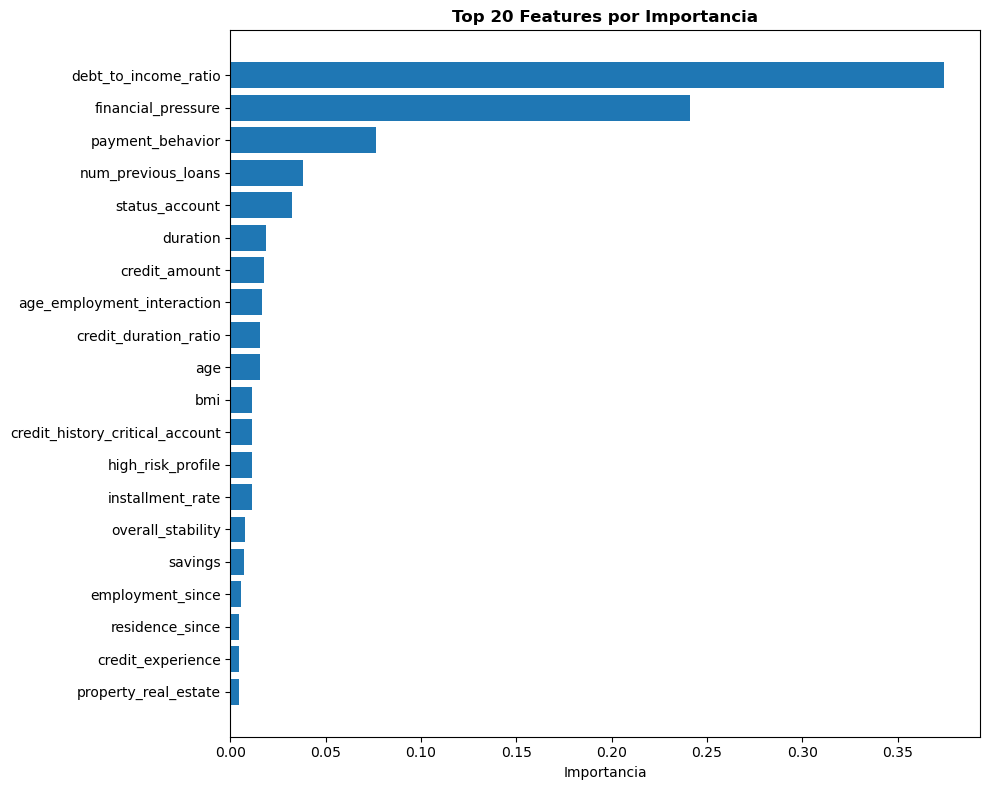

In [31]:
print('EMBEDDED METHOD: Feature Importance (Random Forest)')
print('='*60)
print('\nTop 15 features más importantes:')
print(df_importance.head(15))

# Visualización
plt.figure(figsize=(10, 8))
top_n = 20
plt.barh(range(top_n), df_importance['valor importancia'].head(top_n))
plt.yticks(range(top_n), df_importance['Features names'].head(top_n))
plt.xlabel('Importancia')
plt.title(f'Top {top_n} Features por Importancia', fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

### Comparación rápida de métodos de selección
Comparamos ROC-AUC promedio (CV 5-fold) para justificar qué método podría convenir



In [32]:
summary = pd.DataFrame([
    {"method": "Baseline (sin selección)", "roc_auc_mean": baseline_auc.mean(), "roc_auc_std": baseline_auc.std()},
    {"method": f"Filtro MI (k=15)", "roc_auc_mean": mi_model_auc_mean, "roc_auc_std": mi_model_auc_std},
    {"method": f"Filtro annova (k=15)", "roc_auc_mean": anova_model_auc_mean, "roc_auc_std": anova_model_auc_std},
    {"method": f"Wrapper RFE (n=15)", "roc_auc_mean": rfe_model_auc_mean, "roc_auc_std": rfe_model_auc_std},
    {"method": "Embedded L1 (SelectFromModel)", "roc_auc_mean": sfm_model_auc_mean, "roc_auc_std": sfm_model_auc_std},
]).sort_values("roc_auc_mean", ascending=False)

display(summary)

,method,roc_auc_mean,roc_auc_std
3,Wrapper RFE (n=15),0.995398,0.004855
4,Embedded L1 (SelectFromModel),0.994977,0.004879
0,Baseline (sin selección),0.994729,0.004410
1,Filtro MI (k=15),0.994609,0.004800
2,Filtro annova (k=15),0.994609,0.004800


In [33]:
# Fit del filtro para inspección
mi_model.fit(X_train, y_train)

# Obtener nombres de features post-preprocess
feature_names = mi_model.named_steps["full_Transf"].get_feature_names_out()
selector = mi_model.named_steps["selector"]
print(selector)
df_score_selector=pd.DataFrame({"feature_names":feature_names, "score":selector.scores_})
# mi_scores = pd.Series(selector.scores_, index=feature_names).sort_values(ascending=False)
display(df_score_selector.sort_values(by="score", ascending=False).head(15))


SelectKBest(k=15,
            score_func=<function mutual_info_classif at 0x0000019DB77D7E20>)


,feature_names,score
7,debt_to_income_ratio,0.574593
14,financial_pressure,0.382720
18,payment_behavior,0.146352
15,status_account,0.065055
8,num_previous_loans,0.061290
61,high_risk_profile,0.043673
20,credit_history_critical_account,0.039195
13,overall_stability,0.029875
1,credit_amount,0.027962
11,age_employment_interaction,0.026296


### Interpretacion
Señal fuerte (muy por encima del resto)

- debt_to_income_ratio 0.572
- financial_pressure 0.38

Interpretación: estas son las que más “mueven la aguja” para separar clases.

Por qué tiene sentido de negocio

- debt_to_income_ratio: proxy directo de “carga de deuda” vs capacidad.
- financial_pressure: es feature engineered (ingreso libre estimado). Está alta porque resume capacidad real de pago.


## Decisiones y justificación
- **Filas con muchos faltantes (≥6):** se eliminan por baja proporción y baja confiabilidad de imputación.  
- **Imputación:** numéricas con mediana (robusta), categóricas con `'missing'` para preservar señal de “desconocido”.  
- **Outliers:** se detectan con IQR y z-score; se aplica *IQR clipping* para limitar impacto sin borrar observaciones.  
- **Encoding:** OrdinalEncoder donde hay orden explícito; OneHot en nominales + agrupación de categorías "raras".  
- **Transformación:** PowerTransformer + StandardScaler para algoritmos sensibles a escala (p.ej. modelos lineales).  
- **Feature engineering:** se añaden proxies de capacidad de pago y apalancamiento (≥3 nuevas features).  
- **Selección de variables:** filtro MI + wrapper RFE para reducir dimensionalidad y validar utilidad predictiva.  

### Exportación de dataset para modelado en siguiente Notebook

In [34]:
import pandas as pd

X_train_df = pd.DataFrame(
    X_train_processed,
    columns=feature_names,
    index=y_train.index
)

X_test_df = pd.DataFrame(
    X_test_processed,
    columns=feature_names,
    index=y_test.index
)

train_df = X_train_df.copy()
train_df["target"] = y_train.values

test_df = X_test_df.copy()
test_df["target"] = y_test.values

In [35]:
train_df.to_csv("train_preprocessed.csv", index=False)
test_df.to_csv("test_preprocessed.csv", index=False)